<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.1MB/s 
     |████████████████████████████████| 194kB 40.8MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.2MB 35.6MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

# Collaborative Filtering

One common ML problem to solve is when we have a bunch of cats and a bunch of products, and we want to grift our products to as many cats as possible. In order to maximize our grift we need to find a way to recommend products that are most likely to be useful to the cats we recommend them too. An eggxample of this would be Neggflicks recommending movies, or figuring out what part of a website to highlight for a particular user, or deciding what stories to show in a social media feed.

There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

Collaborative filtering can be applied to a myriad of different areas. Essentially wherever you can think of that findind similarities between groups of people or whatever can be beneficial, so there is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. Latent factors in the neggflicks example are used to create user groups that are similar to one and other when it comes to movies they'll like. 

## A First Look At The Data

Import required libraries:

In [4]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

**Get the Data**

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Create a cross tabs of usersID vs MovieID with the rating as the value:**

In [6]:
df = ratings.pivot(index='user', columns='movie', values='rating')
df = df.fillna('')
df.tail()

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,16

The idea is to train our model to predict how the users would rate the movies they haven't seen yet based on the data we have of the movies they've seen. So the final result would be our model filling in all the empty spaces in the above table with predicted ratings. 

If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and use a combination. For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie *Fury* as:

In [7]:
Fury = np.array([-0.9, 0.9, -0.9])

Then we could represent 3 users who we knew how much the liked these 3 categories as following:

In [8]:
user1 = np.array([0.9,0.9,0.9])
user2 = np.array([-0.9,0.9,-0.8])
user3 = np.array([-0.9, -0.9, 0.9])

Then take the dot product between the fury values and each user to see how likely it would be for each user to like Fury

In [9]:
match = (Fury * user1).sum()
match2 = (Fury * user2).sum()
match3 = (Fury * user3).sum()
match, match2, match3

(-0.81, 2.3400000000000003, -0.81)

Do the same with Titanic:

In [10]:
Titanic = np.array([-0.99, -0.9, 0.7])
match_titanic1 = (Titanic * user1).sum()
match_titanic2 = (Titanic * user2).sum()
match_titanic3 = (Titanic * user3).sum()
match_titanic1, match_titanic2, match_titanic3

(-1.0710000000000002, -0.479, 2.331)

**HOWEVER SINCE WE DON'T KNOW WHAT THE LATENT FACTORS ARE OR HOW TO SCORE THEM WE NEED TO BUILD A MODEL THAT WILL LEARN THEM FOR US BASED ON THE DATA WE PASS IT**

## Learning The Latent Factors

There is surprisingly little difference between specifying the structure of a model, as we did in the last section, and learning one, since we can just use our general gradient descent approach.

**Step 1:** will be like always to randomly initialize some parameters. These parameters will be our set of latent factors for each user and movie. We'll need to decide how many latent factors to use the more the more flexible the model will be but there is a tradeoff as always. In the diagram below we've choosen to use 5 latent factors and each user will have a set of these factors and each movie will have a set of these factors, we can show these randomly initialized values right next to the users and movies in our crosstab, and we can then fill in the dot products for each of these combinations in the middle. 

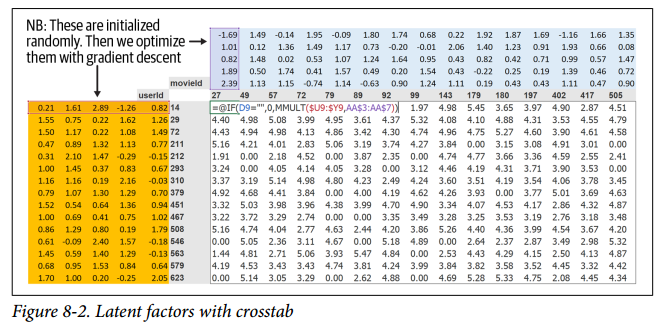

**Step 2:** Calculate the predictions. We do this by taking the dot product of the randomly initialized latent factors of each movie with each user. If for instance the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if a movie has a lot of action or not, the product of those two factors will be high if there is a match and low if there is not.




**Step 3:** Calculate the loss. We can basically use any loss function we want here we'll use MSE.

THAT'S ALL WE NEED. WE CAN NOW GO ON AND OPTIMIZE OUR PARAMETERS (THE LATENT FACTORS) USING SGD (AS WE DO), SUCH AS TO MINIMIZE THE LOSS.

At each step, the sgd optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and step the weights by multiplying the derivative with the learning rate iteratively until the loss gets bedder and bedder.

## Creating the DataLoaders

Let's get the titles of the movies in our dataset to make things more fun and informative:

In [11]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Next merge titles with our `ratings` df since both have movie colummn they df will be merged along that column:

In [13]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


From this table we are going to build a `DataLoaders` object

In [14]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [15]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices.

We need to create tensors for our latent factors corresponding to the diagram above

The code below first calculates the number of use with `len` which is 944 and then the number of movies which is 1655. We've decided to use 5 latent factos for each of our factor matrixes so then we randomly initialize a 944x5 matrix for the `user_factors` and a 1655x5 one for the `movie_factors`. 

Now each user has 5 randomly initialized latent factors associated with them and the same for each movie.

In [16]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors.

In [17]:
user_factors[0:3,0:3]

tensor([[-1.0827,  0.2138,  0.9310],
        [-0.5195,  0.7613, -0.4365],
        [-1.2804,  0.0705,  0.6489]])

In order to index into our matrix of latent factors to chose what user to dot product with what movie we can use one-hot encoding. Below we specify that we want to one hot encode user 3 and 0 every other user. So the vector we create `one_hot_3` will have all elements set to 0 except `one_hot_3[2]` which is the third index (0 indexed). 

We then take that vector and take the dot product with out matrix of user latent factors and that will return to us user 3's latent factors whilst zeroing out every other users latent factors.

So we have essentially used one hot encoding to index into our tensor of latent factors.

In [18]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [19]:
user_factors.t().shape, one_hot_3.shape

(torch.Size([5, 944]), torch.Size([944]))

How this works is that matrix multiplication works by taking the dot product of each row of matrix A with each column of Matrix B. So `user_factor.t()` has 5 rows x 944 columns of values and `one_hot_3` has 944 rows x 1 columns of values. Since the one_hot vector only has 1 value that corresponds to the index of user number 3. The 5 rows that will get multiplied with that 1 value from `user_factor` will be the latent factors for user number 3.

In [20]:
user_factors[3].shape

torch.Size([5])

In [21]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

**In computer vision, we have a very easy way to get all the information of a pixel through its RGB values: each pixel in a colored image is represented by three numbers. Those three numbers give us the redness, the greenness and the blueness, which is enough to get our model to work afterward.**

For the problem at hand, we don't have the same easy way to characterize a user or a movie. There are probably relations with genres: if a given user likes romance, they are likely to give higher scores to romance movies. Other factors might be whether the movie is more action-oriented versus heavy on dialogue, or the presence of a specific actor that a user might particularly like. 

How do we determine numbers to characterize those? The answer is, we don't. We will let our model *learn* them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, `n_factors=5`), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.

**Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by is called the _embedding matrix_.**

## Collaborative Filtering from Scratch

The key idea in object-oriented programming is the *class*. We have been using classes throughout this book, such as `DataLoader`, `string`, and `Learner`. Python also makes it easy for us to create new classes. Here is an example of a simple class:

In [22]:
class Example:
  def __init__(self, a): self.a = a
  def say(self, x): return f'Hello {self.a}, {x}.'

In [23]:
ex = Example('Sam')
ex.say('You will rule the universe')

'Hello Sam, You will rule the universe.'

In [24]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)

In [25]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

Note that the input of the model is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs. As explained before, we use the *embedding* layers to represent our matrices of user and movie latent factors: **AND `y` IS THE VECTOR WITH THE MOVIE RATINGS THAT'S OUR DEPENDENT VARIABLE.**

Here we are choosing to train 50 latent factors, this is a hyperparameter that we can tune though:

In [26]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls=dls, model=model,loss_func=MSELossFlat())

In [27]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:10
1,1.093332,1.109981,00:09
2,0.958258,0.990199,00:09
3,0.814234,0.894916,00:09
4,0.780714,0.882022,00:09


The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use `sigmoid_range`. It's better to have the range go a little bit over 5, so we use `(0, 5.5)` since the sigmoid function asymptote at the top and the bottom so if we want to be able to predict a rating of 5 we need the range to go over 5 since the top and bottom ends are impossible to reach no matter how large or small the inputs (x). 

In [28]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [29]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls=dls, model=model,loss_func=MSELossFlat())

In [30]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:09
1,0.878134,0.918898,00:09
2,0.675850,0.875467,00:09
3,0.483372,0.877939,00:09
4,0.378927,0.881887,00:09


Our loss got a little bit better. Another thing we could do is to add a bias to out user and movie factors. We want to include biases since maybe some users just rate all movies perfectly while others just give out bad ratings. Also some movies are just better than others.

But in our dot product representation we do not have any way to encode either of these things. If all we can say about a movie is, for instance, that it is very sci-fi, very action-oriented, and very not old, then you don't really have any way to say whether most people like it.

**That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores (which can be learned and optimized), and ditto for each movie, that will handle this missing piece very nicely. So first of all, let's adjust our model architecture:**

In [31]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors) # latent factor matrix for users
    self.user_bias = Embedding(n_users, 1)  # create matrix with a bias term for each user
    self.movie_factors = Embedding(n_movies, n_factors) # latenr factor matrix for movies
    self.movie_bias = Embedding(n_movies, 1) # create matrix with a bias term for each movie
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0]) # match the latent factor matrix for users with the actual users
    movies = self.movie_factors(x[:,1]) # match the latent factor matrix for movies with the actual movies
    res = (users * movies).sum(dim=1, keepdim=True) # calculate the dot product between users and each movie to get the estimated rating for each movie by each user
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1]) # add the user and movies bias to each rating
    return sigmoid_range(res, *self.y_range) # force the estimations to be between 0-5.5 by using sigmoid range


In [32]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls=dls, model=model,loss_func=MSELossFlat())

In [33]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:10
1,0.846664,0.865633,00:10
2,0.608090,0.865127,00:10
3,0.413482,0.887318,00:10
4,0.286971,0.894876,00:10


Adding bias terms led us to overfit the data probably since it made our coefficients larger, one way to prevent this is to use regularization or weight decay.

### **Weight Decay**

Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is

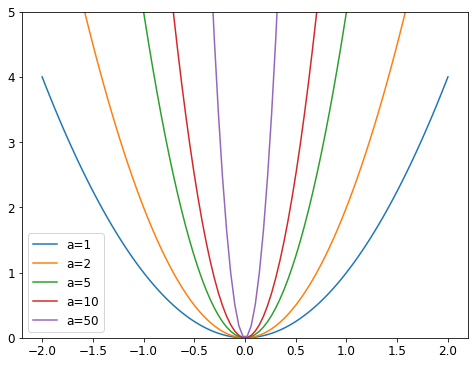

In [34]:
import numpy as np
import matplotlib.pyplot as plt
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.

Limiting our weights from growing too much is going to hinder the training of the model **BY MAKING THE MODEL BEHAVE MORE STABLE AND SENSIBLE IN-BETWEEN THE DATA POINTS**, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):





```
loss_with_wd = loss + wd * (weight**2).sum()
```




In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:





```
dloss_with_wd = wd * 2 * weight
 ```

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. 


To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:

In [35]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls=dls, model=model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:10
1,0.888625,0.882614,00:10
2,0.771066,0.832743,00:10
3,0.599807,0.822374,00:10
4,0.504981,0.822528,00:10


Much bedder!!!

In traditional statistical models we try to avoid overfitting by reducing the number of independent variable that we use, however, in deep learning we instead use regularization.  

### **Creating Our Own Embedding Module**

Optimizers require that they can get all the parameters of a module from the module's `parameters` method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:

In [36]:
class T(Module):
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [37]:
T().parameters()

<generator object Module.parameters at 0x7f0ddfc05e50>

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`:

In [38]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [39]:
T().parameters()

<generator object Module.parameters at 0x7f0de236a9d0>

All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:

In [40]:
class T(Module):
  def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()

L(T().parameters())

(#1) [Parameter containing:
tensor([[-0.1787],
        [-0.6013],
        [ 0.9173]], requires_grad=True)]

In [41]:
class T(Module):
  def __init__(self): self.a = nn.Linear(1, 3, bias=True)

L(T().parameters())

(#2) [Parameter containing:
tensor([[-0.4121],
        [ 0.4035],
        [-0.8395]], requires_grad=True),Parameter containing:
tensor([-0.5477, -0.6977, -0.5846], requires_grad=True)]

In [42]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [43]:
a?

Create a function that creates a tensor of zeros that it then fills with normally distributed values with 0 mean and 0.01 std

In [44]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01)) #the .normal will fill the zeros with numbers with 0 mean and 0.01 std that are normally distributed

In [45]:
create_params((3,3))

Parameter containing:
tensor([[-0.0157,  0.0232,  0.0101],
        [-0.0082, -0.0118,  0.0059],
        [ 0.0095,  0.0098,  0.0051]], requires_grad=True)

Recreate `DotProductBias` but without `Embedding` instead this time we use our `create_params` function that has the same functionality

In [46]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users * movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [47]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.925361,0.949282,00:09
1,0.868873,0.880017,00:09
2,0.721678,0.837263,00:09
3,0.583639,0.826076,00:09
4,0.475162,0.825869,00:09


Nice we are getting same results as when we use `Embedding`

In [48]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

## Interpreting Embeddings and Biases

Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies with the lowest values in the bias vector:

These are the movies that not only the users liked the least but also that they liked much less than was expected:
What it's saying is that for each of these movies, even when a user is very well matched to its latent factors, they still generally don't like it. basically they're not giving the movie a low rating because their biased on the contrary their latent factors indicates that they should like the movie even more but the low rating is given with a very small bias instead. 


In [49]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort(descending=False)[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)',
 'Beautician and the Beast, The (1997)']

These are the movies with the highest values in the bias vector. They are movies that users like a lot even though it was unexpected for them to like them i.e. even when a user isn't very well matched to its latent factos, they still will generally like the movie:  Basically their latent factors predict them to give the movie a poor rating but because the movie is so good they still like it and give it a good rating and this is indicated by the high/large bias term added to their rating for these movies:

In [50]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

**USER BIAS**

User bias tells us which users tend to rate movies poorly or good in general regardless:

Even when a movie is well matched to these users latent factors these users will give it a bad rating:

In [51]:
user_bias = learn.model.user_bias.squeeze()
idxs = user_bias.argsort(descending=True)[:5]
[dls.classes['user'][i] for i in idxs]

[907, 472, 507, 295, 372]

Even when a movie is poorly matched to these users latent factors these users will give it a good rating:

In [52]:
user_bias = learn.model.user_bias.squeeze()
idxs = user_bias.argsort(descending=False)[:5]
[dls.classes['user'][i] for i in idxs]

[181, 405, 774, 933, 445]

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA).


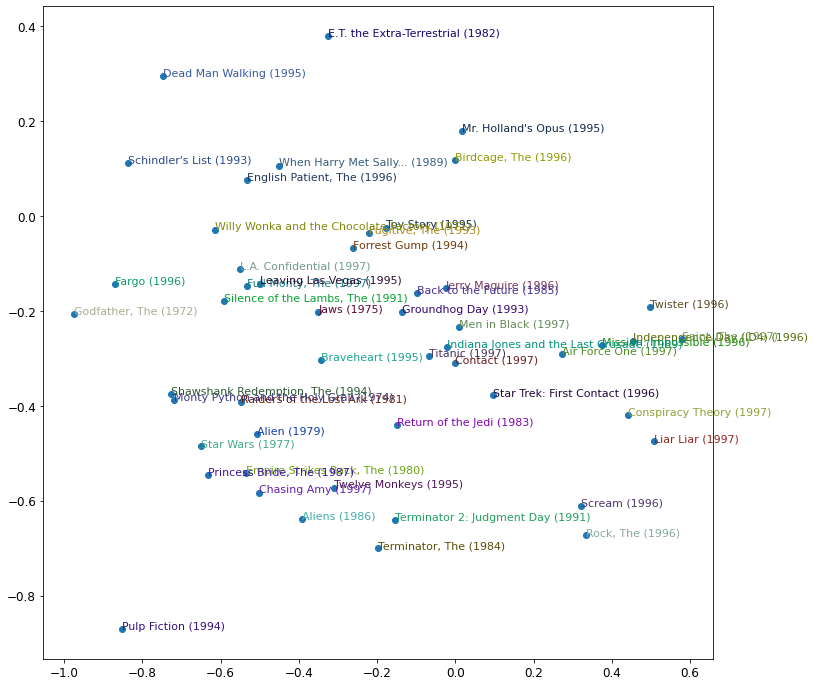

In [53]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We reduced the dimensionality with PCA to 3 principle components and then plotted the main two in the graph above ^

### Using fastai.collab

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's `collab_learner`:

In [54]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [55]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936872,0.953995,00:10
1,0.839974,0.875702,00:10
2,0.721777,0.835359,00:10
3,0.597615,0.820680,00:10
4,0.479481,0.821194,00:10


The names of the layers can be seen by printing the model:

In [56]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

In [57]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

Another interesting thing we can do with these learned embeddings is to look at _distance_.

### Embedding Distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: $\sqrt{x^{2}+y^{2}}$ (assuming that *x* and *y* are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

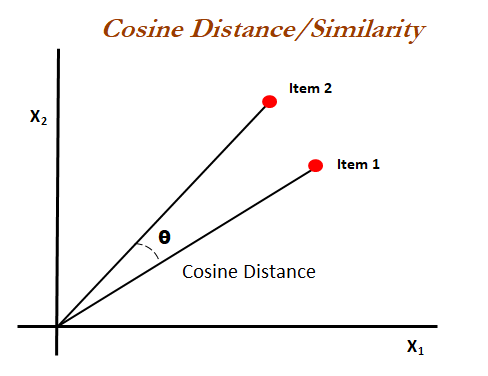

If there were two movies that were nearly identical than their embedding vectors would also be nearly identical because the users that would like them would be nearly identical. Therefore more generally movie similarity can be defined by the similarity of users that like those movies, which means that the distance between two movies embedding vectors defines the similarity of those two movies.

We can use the cosine similarity as illustrated in image above.


image.png

In [58]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Johnny Mnemonic (1995)'

Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?

## Bootstrapping a Collaborative Filtering Model

The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*. The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user?

But even if you are a well-established company with a long history of user transactions, you still have the question: what do you do when a new user signs up? And indeed, what do you do when you add a new product to your portfolio? There is no magic solution to this problem, and really the solutions that we suggest are just variations of *use your common sense*. You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent *average taste*.

**Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector, and the independent variables are the results of the questions that you ask them, along with their signup metadata. We will see in the next section how to create these kinds of tabular models. (You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.)**

One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. **As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.**

Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.

**THE dot product model works quite well, and it is the basis of many successful real-world recommendation systems. This approach to collaborative filtering is known as *probabilistic matrix factorization* (PMF). Another approach, which generally works similarly well given the same data, is deep learning.**

## Deep Learning for Collaborative Filtering

When using a neural network for our collaborative filtering we don't need the number of latent factors to match since we are not taking the dot product. Instead we can axe fastai to return the optimal number of latent factors for our independent variables (users and movies).

In [59]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In order to turn our architecture into a deep learning model, the first step is to take the results
of the embedding lookup and concatenate those activations together. This gives us a
matrix that we can then pass through linear layers and nonlinearities in the usual way

In [60]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1], n_act), # we pass the 74 latent factors from the user and 102 from the items to the first linear hidden layer so the shape of the 1st layer will be 172 x 100 so 172 inputs that become 100 outputs activations
        nn.ReLU(),
        nn.Linear(n_act, 1)) # output shape will be 100 x 1
    self.y_range = y_range

  def forward(self, x):
    embs = self.user_factors(x[:,0]), self.item_factors(x[:,1]) 
    x = self.layers(torch.cat(embs, dim=1)) # concatenate the user and movie embeddings together
    return sigmoid_range(x, *self.y_range)

CollabNN creates our Embedding layers in the same way as previous classes in this
chapter, except that we now use the embs sizes. self.layers is identical to the minineural net we created in Chapter 4 for MNIST. Then, in forward, we apply the
embeddings, concatenate the results, and pass this through the mini-neural net.
Finally, we apply sigmoid_range as we have in previous models.

In [61]:
model = CollabNN(*embs)

In [62]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.943832,0.950393,00:12
1,0.915109,0.900790,00:12
2,0.849733,0.884566,00:12
3,0.814274,0.875442,00:12
4,0.767225,0.877400,00:12


In [63]:
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,1.005487,1.004053,00:16
1,0.865898,0.914499,00:14
2,0.871291,0.887166,00:15
3,0.807317,0.875422,00:15
4,0.796137,0.878082,00:14


`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [65]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

In [64]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
  def __init__(self, emb_szs, layers, **kwargs):
    super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

### **kwargs**

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.

We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`. So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.

## Summary